# Environment Setup

In [3]:
!pip install torch torchvision matplotlib numpy -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

# Synthetic Dot Pattern Generation

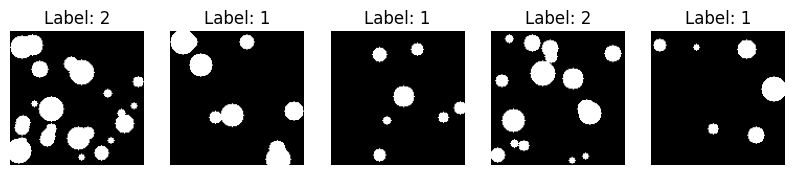

In [4]:
class DotPatternDataset(Dataset):
    def __init__(self, num_samples=5000, image_size=128, categories=(5, 15)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.categories = categories
        self.data, self.labels = self.generate_dataset()

    def generate_dataset(self):
        data = []
        labels = []
        for _ in range(self.num_samples):
            img, label = self.generate_image()
            data.append(img)
            labels.append(label)
        return torch.stack(data), torch.tensor(labels, dtype=torch.long)

    def generate_image(self):
        img = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        num_dots = random.randint(1, 30)
        for _ in range(num_dots):
            x = random.randint(5, self.image_size - 5)
            y = random.randint(5, self.image_size - 5)
            size = random.randint(3, 12)
            img = cv2.circle(img, (x, y), size, (255,), -1)
        img = torch.tensor(img).unsqueeze(0) / 255.0  # Normalize to [0,1]
        label = self.categorize(num_dots)
        return img, label

    def categorize(self, num_dots):
        if num_dots <= self.categories[0]:
            return 0  # Few
        elif num_dots <= self.categories[1]:
            return 1  # Medium
        else:
            return 2  # Many

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Visualize Sample Images
dataset = DotPatternDataset()
plt.figure(figsize=(10, 5))
for i in range(5):
    img, label = dataset[i]
    plt.subplot(1, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
plt.show()

# Data Loaders for Training & Testing

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define CNN Model

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

class NumerosityCNN(nn.Module):
    def __init__(self):
        super(NumerosityCNN, self).__init__()
        self.layer1 = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(32, 64),
            nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 3)  # Few, Medium, Many

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

model = NumerosityCNN()

# Training the Model

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

train_model()

Epoch [1/10], Loss: 1.1785
Epoch [2/10], Loss: 0.3023
Epoch [3/10], Loss: 0.2229
Epoch [4/10], Loss: 0.1650
Epoch [5/10], Loss: 0.1480
Epoch [6/10], Loss: 0.1039
Epoch [7/10], Loss: 0.1091
Epoch [8/10], Loss: 0.0949
Epoch [9/10], Loss: 0.0423
Epoch [10/10], Loss: 0.0364


# Model Evaluation

In [8]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test data: {100 * correct / total:.2f}%')

Accuracy on test data: 91.80%
